In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

DATA="./images"
print(os.listdir(DATA))
image_size = 32
batch_size = 1
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DATA, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)



latent_size = 128



['crops']


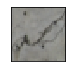

In [2]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=1):
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=1):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(train_dl)



In [3]:
discriminator = nn.Sequential(
    # in: 3 x 32 x 32

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 4 x 4

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 8 x 8

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 16 x 16

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 32 x 32

)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [5]:
fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
#save_samples(0, fixed_latent)

In [6]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [22]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

lr = 0.0002
epochs = 300
losses_g, losses_d, real_scores, fake_scores=fit(epochs, lr)


Epoch [1/300], loss_g: 3.5533, loss_d: 0.0363, real_score: 1.0000, fake_score: 0.0356
Saving 1.png



Epoch [2/300], loss_g: 0.8993, loss_d: 2.4287, real_score: 0.1258, fake_score: 0.2993
Saving 2.png



Epoch [3/300], loss_g: 3.9651, loss_d: 0.1072, real_score: 0.9859, fake_score: 0.0889
Saving 3.png



Epoch [4/300], loss_g: 5.1047, loss_d: 0.2247, real_score: 0.9890, fake_score: 0.1923
Saving 4.png



Epoch [5/300], loss_g: 2.6302, loss_d: 2.5272, real_score: 0.0831, fake_score: 0.0388
Saving 5.png



Epoch [6/300], loss_g: 0.9643, loss_d: 0.4680, real_score: 0.9811, fake_score: 0.3617
Saving 6.png



Epoch [7/300], loss_g: 4.0957, loss_d: 0.3492, real_score: 0.9982, fake_score: 0.2935
Saving 7.png



Epoch [8/300], loss_g: 2.0755, loss_d: 0.0996, real_score: 1.0000, fake_score: 0.0948
Saving 8.png



Epoch [9/300], loss_g: 0.2201, loss_d: 0.8112, real_score: 1.0000, fake_score: 0.5557
Saving 9.png



Epoch [10/300], loss_g: 0.6642, loss_d: 0.4646, real_score: 0.9919, fake_score: 0.3665
Saving 10.png



Epoch [11/300], loss_g: 0.4056, loss_d: 0.9311, real_score: 0.9872, fake_score: 0.6008
Saving 11.png



Epoch [12/300], loss_g: 1.3361, loss_d: 0.7355, real_score: 0.9921, fake_score: 0.5169
Saving 12.png



Epoch [13/300], loss_g: 2.8804, loss_d: 0.1177, real_score: 0.9813, fake_score: 0.0941
Saving 13.png



Epoch [14/300], loss_g: 3.5493, loss_d: 0.6897, real_score: 0.9993, fake_score: 0.4979
Saving 14.png



Epoch [15/300], loss_g: 0.5532, loss_d: 0.7029, real_score: 1.0000, fake_score: 0.5049
Saving 15.png



Epoch [16/300], loss_g: 2.7109, loss_d: 0.0602, real_score: 0.9997, fake_score: 0.0581
Saving 16.png



Epoch [17/300], loss_g: 2.9747, loss_d: 0.4042, real_score: 1.0000, fake_score: 0.3325
Saving 17.png



Epoch [18/300], loss_g: 1.3823, loss_d: 0.0721, real_score: 1.0000, fake_score: 0.0696
Saving 18.png



Epoch [19/300], loss_g: 3.9053, loss_d: 0.1639, real_score: 1.0000, fake_score: 0.1512
Saving 19.png



Epoch [20/300], loss_g: 2.2176, loss_d: 0.2246, real_score: 0.8779, fake_score: 0.0901
Saving 20.png



Epoch [21/300], loss_g: 3.5011, loss_d: 0.1880, real_score: 0.9992, fake_score: 0.1707
Saving 21.png



Epoch [22/300], loss_g: 0.9650, loss_d: 0.3576, real_score: 1.0000, fake_score: 0.3007
Saving 22.png



Epoch [23/300], loss_g: 1.8622, loss_d: 0.1784, real_score: 1.0000, fake_score: 0.1634
Saving 23.png



Epoch [24/300], loss_g: 1.6561, loss_d: 0.0074, real_score: 1.0000, fake_score: 0.0073
Saving 24.png



Epoch [25/300], loss_g: 5.1311, loss_d: 0.3646, real_score: 1.0000, fake_score: 0.3055
Saving 25.png



Epoch [26/300], loss_g: 2.1264, loss_d: 0.1737, real_score: 0.8538, fake_score: 0.0155
Saving 26.png



Epoch [27/300], loss_g: 1.6507, loss_d: 0.2969, real_score: 0.8577, fake_score: 0.1335
Saving 27.png



Epoch [28/300], loss_g: 4.9724, loss_d: 0.1537, real_score: 1.0000, fake_score: 0.1424
Saving 28.png



Epoch [29/300], loss_g: 4.3834, loss_d: 0.3632, real_score: 0.7137, fake_score: 0.0256
Saving 29.png



Epoch [30/300], loss_g: 2.0775, loss_d: 0.2173, real_score: 0.8180, fake_score: 0.0163
Saving 30.png



Epoch [31/300], loss_g: 0.9971, loss_d: 0.0533, real_score: 1.0000, fake_score: 0.0519
Saving 31.png



Epoch [32/300], loss_g: 3.4043, loss_d: 0.2345, real_score: 0.9992, fake_score: 0.2084
Saving 32.png



Epoch [33/300], loss_g: 2.7503, loss_d: 0.0149, real_score: 0.9988, fake_score: 0.0136
Saving 33.png



Epoch [34/300], loss_g: 4.8425, loss_d: 0.2758, real_score: 0.9999, fake_score: 0.2410
Saving 34.png



Epoch [35/300], loss_g: 6.2709, loss_d: 0.0549, real_score: 0.9998, fake_score: 0.0532
Saving 35.png



Epoch [36/300], loss_g: 2.7380, loss_d: 0.0591, real_score: 0.9439, fake_score: 0.0014
Saving 36.png



Epoch [37/300], loss_g: 7.7511, loss_d: 0.0305, real_score: 0.9828, fake_score: 0.0131
Saving 37.png



Epoch [38/300], loss_g: 2.5101, loss_d: 0.0052, real_score: 1.0000, fake_score: 0.0052
Saving 38.png



Epoch [39/300], loss_g: 4.6278, loss_d: 0.0413, real_score: 0.9709, fake_score: 0.0117
Saving 39.png



Epoch [40/300], loss_g: 5.4667, loss_d: 0.4549, real_score: 0.9089, fake_score: 0.3019
Saving 40.png



Epoch [41/300], loss_g: 4.5306, loss_d: 0.0166, real_score: 0.9841, fake_score: 0.0005
Saving 41.png



Epoch [42/300], loss_g: 5.6277, loss_d: 0.1786, real_score: 0.8372, fake_score: 0.0010
Saving 42.png



Epoch [43/300], loss_g: 3.9407, loss_d: 0.7674, real_score: 0.9967, fake_score: 0.5342
Saving 43.png



Epoch [44/300], loss_g: 4.7144, loss_d: 0.0411, real_score: 1.0000, fake_score: 0.0402
Saving 44.png



Epoch [45/300], loss_g: 5.5140, loss_d: 0.0304, real_score: 0.9953, fake_score: 0.0253
Saving 45.png



Epoch [46/300], loss_g: 3.3238, loss_d: 0.3090, real_score: 0.7344, fake_score: 0.0004
Saving 46.png



Epoch [47/300], loss_g: 4.9789, loss_d: 0.0035, real_score: 0.9970, fake_score: 0.0005
Saving 47.png



Epoch [48/300], loss_g: 5.7610, loss_d: 0.8815, real_score: 0.9983, fake_score: 0.5851
Saving 48.png



Epoch [49/300], loss_g: 5.4173, loss_d: 0.0217, real_score: 0.9999, fake_score: 0.0214
Saving 49.png



Epoch [50/300], loss_g: 2.4709, loss_d: 0.0412, real_score: 0.9992, fake_score: 0.0396
Saving 50.png



Epoch [51/300], loss_g: 0.7355, loss_d: 0.0072, real_score: 1.0000, fake_score: 0.0072
Saving 51.png



Epoch [52/300], loss_g: 8.6254, loss_d: 0.0203, real_score: 0.9992, fake_score: 0.0193
Saving 52.png



Epoch [53/300], loss_g: 5.7040, loss_d: 0.7684, real_score: 0.9999, fake_score: 0.5362
Saving 53.png



Epoch [54/300], loss_g: 3.6290, loss_d: 0.3894, real_score: 0.8597, fake_score: 0.2119
Saving 54.png



Epoch [55/300], loss_g: 6.6648, loss_d: 0.0037, real_score: 1.0000, fake_score: 0.0037
Saving 55.png



Epoch [56/300], loss_g: 2.8082, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002
Saving 56.png



Epoch [57/300], loss_g: 0.1532, loss_d: 0.2091, real_score: 0.8113, fake_score: 0.0000
Saving 57.png



Epoch [58/300], loss_g: 1.2095, loss_d: 0.0388, real_score: 0.9998, fake_score: 0.0379
Saving 58.png



Epoch [59/300], loss_g: 1.2301, loss_d: 0.0314, real_score: 1.0000, fake_score: 0.0309
Saving 59.png



Epoch [60/300], loss_g: 1.3813, loss_d: 0.0173, real_score: 0.9907, fake_score: 0.0079
Saving 60.png



Epoch [61/300], loss_g: 2.2278, loss_d: 0.4721, real_score: 0.9996, fake_score: 0.3760
Saving 61.png



Epoch [62/300], loss_g: 1.7073, loss_d: 0.0005, real_score: 0.9996, fake_score: 0.0001
Saving 62.png


KeyboardInterrupt: 

In [29]:
for epoch in range(50000):
    fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)
    save_samples(epoch+1, fixed_latent, show=False)

Saving 1.png
Saving 2.png
Saving 3.png
Saving 4.png
Saving 5.png
Saving 6.png
Saving 7.png
Saving 8.png
Saving 9.png
Saving 10.png
Saving 11.png
Saving 12.png
Saving 13.png
Saving 14.png
Saving 15.png
Saving 16.png
Saving 17.png
Saving 18.png
Saving 19.png
Saving 20.png
Saving 21.png
Saving 22.png
Saving 23.png
Saving 24.png
Saving 25.png
Saving 26.png
Saving 27.png
Saving 28.png
Saving 29.png
Saving 30.png
Saving 31.png
Saving 32.png
Saving 33.png
Saving 34.png
Saving 35.png
Saving 36.png
Saving 37.png
Saving 38.png
Saving 39.png
Saving 40.png
Saving 41.png
Saving 42.png
Saving 43.png
Saving 44.png
Saving 45.png
Saving 46.png
Saving 47.png
Saving 48.png
Saving 49.png
Saving 50.png
Saving 51.png
Saving 52.png
Saving 53.png
Saving 54.png
Saving 55.png
Saving 56.png
Saving 57.png
Saving 58.png
Saving 59.png
Saving 60.png
Saving 61.png
Saving 62.png
Saving 63.png
Saving 64.png
Saving 65.png
Saving 66.png
Saving 67.png
Saving 68.png
Saving 69.png
Saving 70.png
Saving 71.png
Saving 72.png
S

Saving 1093.png
Saving 1094.png
Saving 1095.png
Saving 1096.png
Saving 1097.png
Saving 1098.png
Saving 1099.png
Saving 1100.png
Saving 1101.png
Saving 1102.png
Saving 1103.png
Saving 1104.png
Saving 1105.png
Saving 1106.png
Saving 1107.png
Saving 1108.png
Saving 1109.png
Saving 1110.png
Saving 1111.png
Saving 1112.png
Saving 1113.png
Saving 1114.png
Saving 1115.png
Saving 1116.png
Saving 1117.png
Saving 1118.png
Saving 1119.png
Saving 1120.png
Saving 1121.png
Saving 1122.png
Saving 1123.png
Saving 1124.png
Saving 1125.png
Saving 1126.png
Saving 1127.png
Saving 1128.png
Saving 1129.png
Saving 1130.png
Saving 1131.png
Saving 1132.png
Saving 1133.png
Saving 1134.png
Saving 1135.png
Saving 1136.png
Saving 1137.png
Saving 1138.png
Saving 1139.png
Saving 1140.png
Saving 1141.png
Saving 1142.png
Saving 1143.png
Saving 1144.png
Saving 1145.png
Saving 1146.png
Saving 1147.png
Saving 1148.png
Saving 1149.png
Saving 1150.png
Saving 1151.png
Saving 1152.png
Saving 1153.png
Saving 1154.png
Saving 1

Saving 2117.png
Saving 2118.png
Saving 2119.png
Saving 2120.png
Saving 2121.png
Saving 2122.png
Saving 2123.png
Saving 2124.png
Saving 2125.png
Saving 2126.png
Saving 2127.png
Saving 2128.png
Saving 2129.png
Saving 2130.png
Saving 2131.png
Saving 2132.png
Saving 2133.png
Saving 2134.png
Saving 2135.png
Saving 2136.png
Saving 2137.png
Saving 2138.png
Saving 2139.png
Saving 2140.png
Saving 2141.png
Saving 2142.png
Saving 2143.png
Saving 2144.png
Saving 2145.png
Saving 2146.png
Saving 2147.png
Saving 2148.png
Saving 2149.png
Saving 2150.png
Saving 2151.png
Saving 2152.png
Saving 2153.png
Saving 2154.png
Saving 2155.png
Saving 2156.png
Saving 2157.png
Saving 2158.png
Saving 2159.png
Saving 2160.png
Saving 2161.png
Saving 2162.png
Saving 2163.png
Saving 2164.png
Saving 2165.png
Saving 2166.png
Saving 2167.png
Saving 2168.png
Saving 2169.png
Saving 2170.png
Saving 2171.png
Saving 2172.png
Saving 2173.png
Saving 2174.png
Saving 2175.png
Saving 2176.png
Saving 2177.png
Saving 2178.png
Saving 2

Saving 3141.png
Saving 3142.png
Saving 3143.png
Saving 3144.png
Saving 3145.png
Saving 3146.png
Saving 3147.png
Saving 3148.png
Saving 3149.png
Saving 3150.png
Saving 3151.png
Saving 3152.png
Saving 3153.png
Saving 3154.png
Saving 3155.png
Saving 3156.png
Saving 3157.png
Saving 3158.png
Saving 3159.png
Saving 3160.png
Saving 3161.png
Saving 3162.png
Saving 3163.png
Saving 3164.png
Saving 3165.png
Saving 3166.png
Saving 3167.png
Saving 3168.png
Saving 3169.png
Saving 3170.png
Saving 3171.png
Saving 3172.png
Saving 3173.png
Saving 3174.png
Saving 3175.png
Saving 3176.png
Saving 3177.png
Saving 3178.png
Saving 3179.png
Saving 3180.png
Saving 3181.png
Saving 3182.png
Saving 3183.png
Saving 3184.png
Saving 3185.png
Saving 3186.png
Saving 3187.png
Saving 3188.png
Saving 3189.png
Saving 3190.png
Saving 3191.png
Saving 3192.png
Saving 3193.png
Saving 3194.png
Saving 3195.png
Saving 3196.png
Saving 3197.png
Saving 3198.png
Saving 3199.png
Saving 3200.png
Saving 3201.png
Saving 3202.png
Saving 3

Saving 4165.png
Saving 4166.png
Saving 4167.png
Saving 4168.png
Saving 4169.png
Saving 4170.png
Saving 4171.png
Saving 4172.png
Saving 4173.png
Saving 4174.png
Saving 4175.png
Saving 4176.png
Saving 4177.png
Saving 4178.png
Saving 4179.png
Saving 4180.png
Saving 4181.png
Saving 4182.png
Saving 4183.png
Saving 4184.png
Saving 4185.png
Saving 4186.png
Saving 4187.png
Saving 4188.png
Saving 4189.png
Saving 4190.png
Saving 4191.png
Saving 4192.png
Saving 4193.png
Saving 4194.png
Saving 4195.png
Saving 4196.png
Saving 4197.png
Saving 4198.png
Saving 4199.png
Saving 4200.png
Saving 4201.png
Saving 4202.png
Saving 4203.png
Saving 4204.png
Saving 4205.png
Saving 4206.png
Saving 4207.png
Saving 4208.png
Saving 4209.png
Saving 4210.png
Saving 4211.png
Saving 4212.png
Saving 4213.png
Saving 4214.png
Saving 4215.png
Saving 4216.png
Saving 4217.png
Saving 4218.png
Saving 4219.png
Saving 4220.png
Saving 4221.png
Saving 4222.png
Saving 4223.png
Saving 4224.png
Saving 4225.png
Saving 4226.png
Saving 4

Saving 5189.png
Saving 5190.png
Saving 5191.png
Saving 5192.png
Saving 5193.png
Saving 5194.png
Saving 5195.png
Saving 5196.png
Saving 5197.png
Saving 5198.png
Saving 5199.png
Saving 5200.png
Saving 5201.png
Saving 5202.png
Saving 5203.png
Saving 5204.png
Saving 5205.png
Saving 5206.png
Saving 5207.png
Saving 5208.png
Saving 5209.png
Saving 5210.png
Saving 5211.png
Saving 5212.png
Saving 5213.png
Saving 5214.png
Saving 5215.png
Saving 5216.png
Saving 5217.png
Saving 5218.png
Saving 5219.png
Saving 5220.png
Saving 5221.png
Saving 5222.png
Saving 5223.png
Saving 5224.png
Saving 5225.png
Saving 5226.png
Saving 5227.png
Saving 5228.png
Saving 5229.png
Saving 5230.png
Saving 5231.png
Saving 5232.png
Saving 5233.png
Saving 5234.png
Saving 5235.png
Saving 5236.png
Saving 5237.png
Saving 5238.png
Saving 5239.png
Saving 5240.png
Saving 5241.png
Saving 5242.png
Saving 5243.png
Saving 5244.png
Saving 5245.png
Saving 5246.png
Saving 5247.png
Saving 5248.png
Saving 5249.png
Saving 5250.png
Saving 5

Saving 6213.png
Saving 6214.png
Saving 6215.png
Saving 6216.png
Saving 6217.png
Saving 6218.png
Saving 6219.png
Saving 6220.png
Saving 6221.png
Saving 6222.png
Saving 6223.png
Saving 6224.png
Saving 6225.png
Saving 6226.png
Saving 6227.png
Saving 6228.png
Saving 6229.png
Saving 6230.png
Saving 6231.png
Saving 6232.png
Saving 6233.png
Saving 6234.png
Saving 6235.png
Saving 6236.png
Saving 6237.png
Saving 6238.png
Saving 6239.png
Saving 6240.png
Saving 6241.png
Saving 6242.png
Saving 6243.png
Saving 6244.png
Saving 6245.png
Saving 6246.png
Saving 6247.png
Saving 6248.png
Saving 6249.png
Saving 6250.png
Saving 6251.png
Saving 6252.png
Saving 6253.png
Saving 6254.png
Saving 6255.png
Saving 6256.png
Saving 6257.png
Saving 6258.png
Saving 6259.png
Saving 6260.png
Saving 6261.png
Saving 6262.png
Saving 6263.png
Saving 6264.png
Saving 6265.png
Saving 6266.png
Saving 6267.png
Saving 6268.png
Saving 6269.png
Saving 6270.png
Saving 6271.png
Saving 6272.png
Saving 6273.png
Saving 6274.png
Saving 6

Saving 7237.png
Saving 7238.png
Saving 7239.png
Saving 7240.png
Saving 7241.png
Saving 7242.png
Saving 7243.png
Saving 7244.png
Saving 7245.png
Saving 7246.png
Saving 7247.png
Saving 7248.png
Saving 7249.png
Saving 7250.png
Saving 7251.png
Saving 7252.png
Saving 7253.png
Saving 7254.png
Saving 7255.png
Saving 7256.png
Saving 7257.png
Saving 7258.png
Saving 7259.png
Saving 7260.png
Saving 7261.png
Saving 7262.png
Saving 7263.png
Saving 7264.png
Saving 7265.png
Saving 7266.png
Saving 7267.png
Saving 7268.png
Saving 7269.png
Saving 7270.png
Saving 7271.png
Saving 7272.png
Saving 7273.png
Saving 7274.png
Saving 7275.png
Saving 7276.png
Saving 7277.png
Saving 7278.png
Saving 7279.png
Saving 7280.png
Saving 7281.png
Saving 7282.png
Saving 7283.png
Saving 7284.png
Saving 7285.png
Saving 7286.png
Saving 7287.png
Saving 7288.png
Saving 7289.png
Saving 7290.png
Saving 7291.png
Saving 7292.png
Saving 7293.png
Saving 7294.png
Saving 7295.png
Saving 7296.png
Saving 7297.png
Saving 7298.png
Saving 7

Saving 8261.png
Saving 8262.png
Saving 8263.png
Saving 8264.png
Saving 8265.png
Saving 8266.png
Saving 8267.png
Saving 8268.png
Saving 8269.png
Saving 8270.png
Saving 8271.png
Saving 8272.png
Saving 8273.png
Saving 8274.png
Saving 8275.png
Saving 8276.png
Saving 8277.png
Saving 8278.png
Saving 8279.png
Saving 8280.png
Saving 8281.png
Saving 8282.png
Saving 8283.png
Saving 8284.png
Saving 8285.png
Saving 8286.png
Saving 8287.png
Saving 8288.png
Saving 8289.png
Saving 8290.png
Saving 8291.png
Saving 8292.png
Saving 8293.png
Saving 8294.png
Saving 8295.png
Saving 8296.png
Saving 8297.png
Saving 8298.png
Saving 8299.png
Saving 8300.png
Saving 8301.png
Saving 8302.png
Saving 8303.png
Saving 8304.png
Saving 8305.png
Saving 8306.png
Saving 8307.png
Saving 8308.png
Saving 8309.png
Saving 8310.png
Saving 8311.png
Saving 8312.png
Saving 8313.png
Saving 8314.png
Saving 8315.png
Saving 8316.png
Saving 8317.png
Saving 8318.png
Saving 8319.png
Saving 8320.png
Saving 8321.png
Saving 8322.png
Saving 8

Saving 9285.png
Saving 9286.png
Saving 9287.png
Saving 9288.png
Saving 9289.png
Saving 9290.png
Saving 9291.png
Saving 9292.png
Saving 9293.png
Saving 9294.png
Saving 9295.png
Saving 9296.png
Saving 9297.png
Saving 9298.png
Saving 9299.png
Saving 9300.png
Saving 9301.png
Saving 9302.png
Saving 9303.png
Saving 9304.png
Saving 9305.png
Saving 9306.png
Saving 9307.png
Saving 9308.png
Saving 9309.png
Saving 9310.png
Saving 9311.png
Saving 9312.png
Saving 9313.png
Saving 9314.png
Saving 9315.png
Saving 9316.png
Saving 9317.png
Saving 9318.png
Saving 9319.png
Saving 9320.png
Saving 9321.png
Saving 9322.png
Saving 9323.png
Saving 9324.png
Saving 9325.png
Saving 9326.png
Saving 9327.png
Saving 9328.png
Saving 9329.png
Saving 9330.png
Saving 9331.png
Saving 9332.png
Saving 9333.png
Saving 9334.png
Saving 9335.png
Saving 9336.png
Saving 9337.png
Saving 9338.png
Saving 9339.png
Saving 9340.png
Saving 9341.png
Saving 9342.png
Saving 9343.png
Saving 9344.png
Saving 9345.png
Saving 9346.png
Saving 9

Saving 10290.png
Saving 10291.png
Saving 10292.png
Saving 10293.png
Saving 10294.png
Saving 10295.png
Saving 10296.png
Saving 10297.png
Saving 10298.png
Saving 10299.png
Saving 10300.png
Saving 10301.png
Saving 10302.png
Saving 10303.png
Saving 10304.png
Saving 10305.png
Saving 10306.png
Saving 10307.png
Saving 10308.png
Saving 10309.png
Saving 10310.png
Saving 10311.png
Saving 10312.png
Saving 10313.png
Saving 10314.png
Saving 10315.png
Saving 10316.png
Saving 10317.png
Saving 10318.png
Saving 10319.png
Saving 10320.png
Saving 10321.png
Saving 10322.png
Saving 10323.png
Saving 10324.png
Saving 10325.png
Saving 10326.png
Saving 10327.png
Saving 10328.png
Saving 10329.png
Saving 10330.png
Saving 10331.png
Saving 10332.png
Saving 10333.png
Saving 10334.png
Saving 10335.png
Saving 10336.png
Saving 10337.png
Saving 10338.png
Saving 10339.png
Saving 10340.png
Saving 10341.png
Saving 10342.png
Saving 10343.png
Saving 10344.png
Saving 10345.png
Saving 10346.png
Saving 10347.png
Saving 10348.p

Saving 11252.png
Saving 11253.png
Saving 11254.png
Saving 11255.png
Saving 11256.png
Saving 11257.png
Saving 11258.png
Saving 11259.png
Saving 11260.png
Saving 11261.png
Saving 11262.png
Saving 11263.png
Saving 11264.png
Saving 11265.png
Saving 11266.png
Saving 11267.png
Saving 11268.png
Saving 11269.png
Saving 11270.png
Saving 11271.png
Saving 11272.png
Saving 11273.png
Saving 11274.png
Saving 11275.png
Saving 11276.png
Saving 11277.png
Saving 11278.png
Saving 11279.png
Saving 11280.png
Saving 11281.png
Saving 11282.png
Saving 11283.png
Saving 11284.png
Saving 11285.png
Saving 11286.png
Saving 11287.png
Saving 11288.png
Saving 11289.png
Saving 11290.png
Saving 11291.png
Saving 11292.png
Saving 11293.png
Saving 11294.png
Saving 11295.png
Saving 11296.png
Saving 11297.png
Saving 11298.png
Saving 11299.png
Saving 11300.png
Saving 11301.png
Saving 11302.png
Saving 11303.png
Saving 11304.png
Saving 11305.png
Saving 11306.png
Saving 11307.png
Saving 11308.png
Saving 11309.png
Saving 11310.p

Saving 12214.png
Saving 12215.png
Saving 12216.png
Saving 12217.png
Saving 12218.png
Saving 12219.png
Saving 12220.png
Saving 12221.png
Saving 12222.png
Saving 12223.png
Saving 12224.png
Saving 12225.png
Saving 12226.png
Saving 12227.png
Saving 12228.png
Saving 12229.png
Saving 12230.png
Saving 12231.png
Saving 12232.png
Saving 12233.png
Saving 12234.png
Saving 12235.png
Saving 12236.png
Saving 12237.png
Saving 12238.png
Saving 12239.png
Saving 12240.png
Saving 12241.png
Saving 12242.png
Saving 12243.png
Saving 12244.png
Saving 12245.png
Saving 12246.png
Saving 12247.png
Saving 12248.png
Saving 12249.png
Saving 12250.png
Saving 12251.png
Saving 12252.png
Saving 12253.png
Saving 12254.png
Saving 12255.png
Saving 12256.png
Saving 12257.png
Saving 12258.png
Saving 12259.png
Saving 12260.png
Saving 12261.png
Saving 12262.png
Saving 12263.png
Saving 12264.png
Saving 12265.png
Saving 12266.png
Saving 12267.png
Saving 12268.png
Saving 12269.png
Saving 12270.png
Saving 12271.png
Saving 12272.p

Saving 13176.png
Saving 13177.png
Saving 13178.png
Saving 13179.png
Saving 13180.png
Saving 13181.png
Saving 13182.png
Saving 13183.png
Saving 13184.png
Saving 13185.png
Saving 13186.png
Saving 13187.png
Saving 13188.png
Saving 13189.png
Saving 13190.png
Saving 13191.png
Saving 13192.png
Saving 13193.png
Saving 13194.png
Saving 13195.png
Saving 13196.png
Saving 13197.png
Saving 13198.png
Saving 13199.png
Saving 13200.png
Saving 13201.png
Saving 13202.png
Saving 13203.png
Saving 13204.png
Saving 13205.png
Saving 13206.png
Saving 13207.png
Saving 13208.png
Saving 13209.png
Saving 13210.png
Saving 13211.png
Saving 13212.png
Saving 13213.png
Saving 13214.png
Saving 13215.png
Saving 13216.png
Saving 13217.png
Saving 13218.png
Saving 13219.png
Saving 13220.png
Saving 13221.png
Saving 13222.png
Saving 13223.png
Saving 13224.png
Saving 13225.png
Saving 13226.png
Saving 13227.png
Saving 13228.png
Saving 13229.png
Saving 13230.png
Saving 13231.png
Saving 13232.png
Saving 13233.png
Saving 13234.p

Saving 14138.png
Saving 14139.png
Saving 14140.png
Saving 14141.png
Saving 14142.png
Saving 14143.png
Saving 14144.png
Saving 14145.png
Saving 14146.png
Saving 14147.png
Saving 14148.png
Saving 14149.png
Saving 14150.png
Saving 14151.png
Saving 14152.png
Saving 14153.png
Saving 14154.png
Saving 14155.png
Saving 14156.png
Saving 14157.png
Saving 14158.png
Saving 14159.png
Saving 14160.png
Saving 14161.png
Saving 14162.png
Saving 14163.png
Saving 14164.png
Saving 14165.png
Saving 14166.png
Saving 14167.png
Saving 14168.png
Saving 14169.png
Saving 14170.png
Saving 14171.png
Saving 14172.png
Saving 14173.png
Saving 14174.png
Saving 14175.png
Saving 14176.png
Saving 14177.png
Saving 14178.png
Saving 14179.png
Saving 14180.png
Saving 14181.png
Saving 14182.png
Saving 14183.png
Saving 14184.png
Saving 14185.png
Saving 14186.png
Saving 14187.png
Saving 14188.png
Saving 14189.png
Saving 14190.png
Saving 14191.png
Saving 14192.png
Saving 14193.png
Saving 14194.png
Saving 14195.png
Saving 14196.p

Saving 15100.png
Saving 15101.png
Saving 15102.png
Saving 15103.png
Saving 15104.png
Saving 15105.png
Saving 15106.png
Saving 15107.png
Saving 15108.png
Saving 15109.png
Saving 15110.png
Saving 15111.png
Saving 15112.png
Saving 15113.png
Saving 15114.png
Saving 15115.png
Saving 15116.png
Saving 15117.png
Saving 15118.png
Saving 15119.png
Saving 15120.png
Saving 15121.png
Saving 15122.png
Saving 15123.png
Saving 15124.png
Saving 15125.png
Saving 15126.png
Saving 15127.png
Saving 15128.png
Saving 15129.png
Saving 15130.png
Saving 15131.png
Saving 15132.png
Saving 15133.png
Saving 15134.png
Saving 15135.png
Saving 15136.png
Saving 15137.png
Saving 15138.png
Saving 15139.png
Saving 15140.png
Saving 15141.png
Saving 15142.png
Saving 15143.png
Saving 15144.png
Saving 15145.png
Saving 15146.png
Saving 15147.png
Saving 15148.png
Saving 15149.png
Saving 15150.png
Saving 15151.png
Saving 15152.png
Saving 15153.png
Saving 15154.png
Saving 15155.png
Saving 15156.png
Saving 15157.png
Saving 15158.p

Saving 16062.png
Saving 16063.png
Saving 16064.png
Saving 16065.png
Saving 16066.png
Saving 16067.png
Saving 16068.png
Saving 16069.png
Saving 16070.png
Saving 16071.png
Saving 16072.png
Saving 16073.png
Saving 16074.png
Saving 16075.png
Saving 16076.png
Saving 16077.png
Saving 16078.png
Saving 16079.png
Saving 16080.png
Saving 16081.png
Saving 16082.png
Saving 16083.png
Saving 16084.png
Saving 16085.png
Saving 16086.png
Saving 16087.png
Saving 16088.png
Saving 16089.png
Saving 16090.png
Saving 16091.png
Saving 16092.png
Saving 16093.png
Saving 16094.png
Saving 16095.png
Saving 16096.png
Saving 16097.png
Saving 16098.png
Saving 16099.png
Saving 16100.png
Saving 16101.png
Saving 16102.png
Saving 16103.png
Saving 16104.png
Saving 16105.png
Saving 16106.png
Saving 16107.png
Saving 16108.png
Saving 16109.png
Saving 16110.png
Saving 16111.png
Saving 16112.png
Saving 16113.png
Saving 16114.png
Saving 16115.png
Saving 16116.png
Saving 16117.png
Saving 16118.png
Saving 16119.png
Saving 16120.p

Saving 17024.png
Saving 17025.png
Saving 17026.png
Saving 17027.png
Saving 17028.png
Saving 17029.png
Saving 17030.png
Saving 17031.png
Saving 17032.png
Saving 17033.png
Saving 17034.png
Saving 17035.png
Saving 17036.png
Saving 17037.png
Saving 17038.png
Saving 17039.png
Saving 17040.png
Saving 17041.png
Saving 17042.png
Saving 17043.png
Saving 17044.png
Saving 17045.png
Saving 17046.png
Saving 17047.png
Saving 17048.png
Saving 17049.png
Saving 17050.png
Saving 17051.png
Saving 17052.png
Saving 17053.png
Saving 17054.png
Saving 17055.png
Saving 17056.png
Saving 17057.png
Saving 17058.png
Saving 17059.png
Saving 17060.png
Saving 17061.png
Saving 17062.png
Saving 17063.png
Saving 17064.png
Saving 17065.png
Saving 17066.png
Saving 17067.png
Saving 17068.png
Saving 17069.png
Saving 17070.png
Saving 17071.png
Saving 17072.png
Saving 17073.png
Saving 17074.png
Saving 17075.png
Saving 17076.png
Saving 17077.png
Saving 17078.png
Saving 17079.png
Saving 17080.png
Saving 17081.png
Saving 17082.p

Saving 17986.png
Saving 17987.png
Saving 17988.png
Saving 17989.png
Saving 17990.png
Saving 17991.png
Saving 17992.png
Saving 17993.png
Saving 17994.png
Saving 17995.png
Saving 17996.png
Saving 17997.png
Saving 17998.png
Saving 17999.png
Saving 18000.png
Saving 18001.png
Saving 18002.png
Saving 18003.png
Saving 18004.png
Saving 18005.png
Saving 18006.png
Saving 18007.png
Saving 18008.png
Saving 18009.png
Saving 18010.png
Saving 18011.png
Saving 18012.png
Saving 18013.png
Saving 18014.png
Saving 18015.png
Saving 18016.png
Saving 18017.png
Saving 18018.png
Saving 18019.png
Saving 18020.png
Saving 18021.png
Saving 18022.png
Saving 18023.png
Saving 18024.png
Saving 18025.png
Saving 18026.png
Saving 18027.png
Saving 18028.png
Saving 18029.png
Saving 18030.png
Saving 18031.png
Saving 18032.png
Saving 18033.png
Saving 18034.png
Saving 18035.png
Saving 18036.png
Saving 18037.png
Saving 18038.png
Saving 18039.png
Saving 18040.png
Saving 18041.png
Saving 18042.png
Saving 18043.png
Saving 18044.p

Saving 18948.png
Saving 18949.png
Saving 18950.png
Saving 18951.png
Saving 18952.png
Saving 18953.png
Saving 18954.png
Saving 18955.png
Saving 18956.png
Saving 18957.png
Saving 18958.png
Saving 18959.png
Saving 18960.png
Saving 18961.png
Saving 18962.png
Saving 18963.png
Saving 18964.png
Saving 18965.png
Saving 18966.png
Saving 18967.png
Saving 18968.png
Saving 18969.png
Saving 18970.png
Saving 18971.png
Saving 18972.png
Saving 18973.png
Saving 18974.png
Saving 18975.png
Saving 18976.png
Saving 18977.png
Saving 18978.png
Saving 18979.png
Saving 18980.png
Saving 18981.png
Saving 18982.png
Saving 18983.png
Saving 18984.png
Saving 18985.png
Saving 18986.png
Saving 18987.png
Saving 18988.png
Saving 18989.png
Saving 18990.png
Saving 18991.png
Saving 18992.png
Saving 18993.png
Saving 18994.png
Saving 18995.png
Saving 18996.png
Saving 18997.png
Saving 18998.png
Saving 18999.png
Saving 19000.png
Saving 19001.png
Saving 19002.png
Saving 19003.png
Saving 19004.png
Saving 19005.png
Saving 19006.p

Saving 19910.png
Saving 19911.png
Saving 19912.png
Saving 19913.png
Saving 19914.png
Saving 19915.png
Saving 19916.png
Saving 19917.png
Saving 19918.png
Saving 19919.png
Saving 19920.png
Saving 19921.png
Saving 19922.png
Saving 19923.png
Saving 19924.png
Saving 19925.png
Saving 19926.png
Saving 19927.png
Saving 19928.png
Saving 19929.png
Saving 19930.png
Saving 19931.png
Saving 19932.png
Saving 19933.png
Saving 19934.png
Saving 19935.png
Saving 19936.png
Saving 19937.png
Saving 19938.png
Saving 19939.png
Saving 19940.png
Saving 19941.png
Saving 19942.png
Saving 19943.png
Saving 19944.png
Saving 19945.png
Saving 19946.png
Saving 19947.png
Saving 19948.png
Saving 19949.png
Saving 19950.png
Saving 19951.png
Saving 19952.png
Saving 19953.png
Saving 19954.png
Saving 19955.png
Saving 19956.png
Saving 19957.png
Saving 19958.png
Saving 19959.png
Saving 19960.png
Saving 19961.png
Saving 19962.png
Saving 19963.png
Saving 19964.png
Saving 19965.png
Saving 19966.png
Saving 19967.png
Saving 19968.p

Saving 20872.png
Saving 20873.png
Saving 20874.png
Saving 20875.png
Saving 20876.png
Saving 20877.png
Saving 20878.png
Saving 20879.png
Saving 20880.png
Saving 20881.png
Saving 20882.png
Saving 20883.png
Saving 20884.png
Saving 20885.png
Saving 20886.png
Saving 20887.png
Saving 20888.png
Saving 20889.png
Saving 20890.png
Saving 20891.png
Saving 20892.png
Saving 20893.png
Saving 20894.png
Saving 20895.png
Saving 20896.png
Saving 20897.png
Saving 20898.png
Saving 20899.png
Saving 20900.png
Saving 20901.png
Saving 20902.png
Saving 20903.png
Saving 20904.png
Saving 20905.png
Saving 20906.png
Saving 20907.png
Saving 20908.png
Saving 20909.png
Saving 20910.png
Saving 20911.png
Saving 20912.png
Saving 20913.png
Saving 20914.png
Saving 20915.png
Saving 20916.png
Saving 20917.png
Saving 20918.png
Saving 20919.png
Saving 20920.png
Saving 20921.png
Saving 20922.png
Saving 20923.png
Saving 20924.png
Saving 20925.png
Saving 20926.png
Saving 20927.png
Saving 20928.png
Saving 20929.png
Saving 20930.p

Saving 21834.png
Saving 21835.png
Saving 21836.png
Saving 21837.png
Saving 21838.png
Saving 21839.png
Saving 21840.png
Saving 21841.png
Saving 21842.png
Saving 21843.png
Saving 21844.png
Saving 21845.png
Saving 21846.png
Saving 21847.png
Saving 21848.png
Saving 21849.png
Saving 21850.png
Saving 21851.png
Saving 21852.png
Saving 21853.png
Saving 21854.png
Saving 21855.png
Saving 21856.png
Saving 21857.png
Saving 21858.png
Saving 21859.png
Saving 21860.png
Saving 21861.png
Saving 21862.png
Saving 21863.png
Saving 21864.png
Saving 21865.png
Saving 21866.png
Saving 21867.png
Saving 21868.png
Saving 21869.png
Saving 21870.png
Saving 21871.png
Saving 21872.png
Saving 21873.png
Saving 21874.png
Saving 21875.png
Saving 21876.png
Saving 21877.png
Saving 21878.png
Saving 21879.png
Saving 21880.png
Saving 21881.png
Saving 21882.png
Saving 21883.png
Saving 21884.png
Saving 21885.png
Saving 21886.png
Saving 21887.png
Saving 21888.png
Saving 21889.png
Saving 21890.png
Saving 21891.png
Saving 21892.p

Saving 22796.png
Saving 22797.png
Saving 22798.png
Saving 22799.png
Saving 22800.png
Saving 22801.png
Saving 22802.png
Saving 22803.png
Saving 22804.png
Saving 22805.png
Saving 22806.png
Saving 22807.png
Saving 22808.png
Saving 22809.png
Saving 22810.png
Saving 22811.png
Saving 22812.png
Saving 22813.png
Saving 22814.png
Saving 22815.png
Saving 22816.png
Saving 22817.png
Saving 22818.png
Saving 22819.png
Saving 22820.png
Saving 22821.png
Saving 22822.png
Saving 22823.png
Saving 22824.png
Saving 22825.png
Saving 22826.png
Saving 22827.png
Saving 22828.png
Saving 22829.png
Saving 22830.png
Saving 22831.png
Saving 22832.png
Saving 22833.png
Saving 22834.png
Saving 22835.png
Saving 22836.png
Saving 22837.png
Saving 22838.png
Saving 22839.png
Saving 22840.png
Saving 22841.png
Saving 22842.png
Saving 22843.png
Saving 22844.png
Saving 22845.png
Saving 22846.png
Saving 22847.png
Saving 22848.png
Saving 22849.png
Saving 22850.png
Saving 22851.png
Saving 22852.png
Saving 22853.png
Saving 22854.p

Saving 23758.png
Saving 23759.png
Saving 23760.png
Saving 23761.png
Saving 23762.png
Saving 23763.png
Saving 23764.png
Saving 23765.png
Saving 23766.png
Saving 23767.png
Saving 23768.png
Saving 23769.png
Saving 23770.png
Saving 23771.png
Saving 23772.png
Saving 23773.png
Saving 23774.png
Saving 23775.png
Saving 23776.png
Saving 23777.png
Saving 23778.png
Saving 23779.png
Saving 23780.png
Saving 23781.png
Saving 23782.png
Saving 23783.png
Saving 23784.png
Saving 23785.png
Saving 23786.png
Saving 23787.png
Saving 23788.png
Saving 23789.png
Saving 23790.png
Saving 23791.png
Saving 23792.png
Saving 23793.png
Saving 23794.png
Saving 23795.png
Saving 23796.png
Saving 23797.png
Saving 23798.png
Saving 23799.png
Saving 23800.png
Saving 23801.png
Saving 23802.png
Saving 23803.png
Saving 23804.png
Saving 23805.png
Saving 23806.png
Saving 23807.png
Saving 23808.png
Saving 23809.png
Saving 23810.png
Saving 23811.png
Saving 23812.png
Saving 23813.png
Saving 23814.png
Saving 23815.png
Saving 23816.p

Saving 24720.png
Saving 24721.png
Saving 24722.png
Saving 24723.png
Saving 24724.png
Saving 24725.png
Saving 24726.png
Saving 24727.png
Saving 24728.png
Saving 24729.png
Saving 24730.png
Saving 24731.png
Saving 24732.png
Saving 24733.png
Saving 24734.png
Saving 24735.png
Saving 24736.png
Saving 24737.png
Saving 24738.png
Saving 24739.png
Saving 24740.png
Saving 24741.png
Saving 24742.png
Saving 24743.png
Saving 24744.png
Saving 24745.png
Saving 24746.png
Saving 24747.png
Saving 24748.png
Saving 24749.png
Saving 24750.png
Saving 24751.png
Saving 24752.png
Saving 24753.png
Saving 24754.png
Saving 24755.png
Saving 24756.png
Saving 24757.png
Saving 24758.png
Saving 24759.png
Saving 24760.png
Saving 24761.png
Saving 24762.png
Saving 24763.png
Saving 24764.png
Saving 24765.png
Saving 24766.png
Saving 24767.png
Saving 24768.png
Saving 24769.png
Saving 24770.png
Saving 24771.png
Saving 24772.png
Saving 24773.png
Saving 24774.png
Saving 24775.png
Saving 24776.png
Saving 24777.png
Saving 24778.p

Saving 25682.png
Saving 25683.png
Saving 25684.png
Saving 25685.png
Saving 25686.png
Saving 25687.png
Saving 25688.png
Saving 25689.png
Saving 25690.png
Saving 25691.png
Saving 25692.png
Saving 25693.png
Saving 25694.png
Saving 25695.png
Saving 25696.png
Saving 25697.png
Saving 25698.png
Saving 25699.png
Saving 25700.png
Saving 25701.png
Saving 25702.png
Saving 25703.png
Saving 25704.png
Saving 25705.png
Saving 25706.png
Saving 25707.png
Saving 25708.png
Saving 25709.png
Saving 25710.png
Saving 25711.png
Saving 25712.png
Saving 25713.png
Saving 25714.png
Saving 25715.png
Saving 25716.png
Saving 25717.png
Saving 25718.png
Saving 25719.png
Saving 25720.png
Saving 25721.png
Saving 25722.png
Saving 25723.png
Saving 25724.png
Saving 25725.png
Saving 25726.png
Saving 25727.png
Saving 25728.png
Saving 25729.png
Saving 25730.png
Saving 25731.png
Saving 25732.png
Saving 25733.png
Saving 25734.png
Saving 25735.png
Saving 25736.png
Saving 25737.png
Saving 25738.png
Saving 25739.png
Saving 25740.p

Saving 26644.png
Saving 26645.png
Saving 26646.png
Saving 26647.png
Saving 26648.png
Saving 26649.png
Saving 26650.png
Saving 26651.png
Saving 26652.png
Saving 26653.png
Saving 26654.png
Saving 26655.png
Saving 26656.png
Saving 26657.png
Saving 26658.png
Saving 26659.png
Saving 26660.png
Saving 26661.png
Saving 26662.png
Saving 26663.png
Saving 26664.png
Saving 26665.png
Saving 26666.png
Saving 26667.png
Saving 26668.png
Saving 26669.png
Saving 26670.png
Saving 26671.png
Saving 26672.png
Saving 26673.png
Saving 26674.png
Saving 26675.png
Saving 26676.png
Saving 26677.png
Saving 26678.png
Saving 26679.png
Saving 26680.png
Saving 26681.png
Saving 26682.png
Saving 26683.png
Saving 26684.png
Saving 26685.png
Saving 26686.png
Saving 26687.png
Saving 26688.png
Saving 26689.png
Saving 26690.png
Saving 26691.png
Saving 26692.png
Saving 26693.png
Saving 26694.png
Saving 26695.png
Saving 26696.png
Saving 26697.png
Saving 26698.png
Saving 26699.png
Saving 26700.png
Saving 26701.png
Saving 26702.p

Saving 27606.png
Saving 27607.png
Saving 27608.png
Saving 27609.png
Saving 27610.png
Saving 27611.png
Saving 27612.png
Saving 27613.png
Saving 27614.png
Saving 27615.png
Saving 27616.png
Saving 27617.png
Saving 27618.png
Saving 27619.png
Saving 27620.png
Saving 27621.png
Saving 27622.png
Saving 27623.png
Saving 27624.png
Saving 27625.png
Saving 27626.png
Saving 27627.png
Saving 27628.png
Saving 27629.png
Saving 27630.png
Saving 27631.png
Saving 27632.png
Saving 27633.png
Saving 27634.png
Saving 27635.png
Saving 27636.png
Saving 27637.png
Saving 27638.png
Saving 27639.png
Saving 27640.png
Saving 27641.png
Saving 27642.png
Saving 27643.png
Saving 27644.png
Saving 27645.png
Saving 27646.png
Saving 27647.png
Saving 27648.png
Saving 27649.png
Saving 27650.png
Saving 27651.png
Saving 27652.png
Saving 27653.png
Saving 27654.png
Saving 27655.png
Saving 27656.png
Saving 27657.png
Saving 27658.png
Saving 27659.png
Saving 27660.png
Saving 27661.png
Saving 27662.png
Saving 27663.png
Saving 27664.p

Saving 28568.png
Saving 28569.png
Saving 28570.png
Saving 28571.png
Saving 28572.png
Saving 28573.png
Saving 28574.png
Saving 28575.png
Saving 28576.png
Saving 28577.png
Saving 28578.png
Saving 28579.png
Saving 28580.png
Saving 28581.png
Saving 28582.png
Saving 28583.png
Saving 28584.png
Saving 28585.png
Saving 28586.png
Saving 28587.png
Saving 28588.png
Saving 28589.png
Saving 28590.png
Saving 28591.png
Saving 28592.png
Saving 28593.png
Saving 28594.png
Saving 28595.png
Saving 28596.png
Saving 28597.png
Saving 28598.png
Saving 28599.png
Saving 28600.png
Saving 28601.png
Saving 28602.png
Saving 28603.png
Saving 28604.png
Saving 28605.png
Saving 28606.png
Saving 28607.png
Saving 28608.png
Saving 28609.png
Saving 28610.png
Saving 28611.png
Saving 28612.png
Saving 28613.png
Saving 28614.png
Saving 28615.png
Saving 28616.png
Saving 28617.png
Saving 28618.png
Saving 28619.png
Saving 28620.png
Saving 28621.png
Saving 28622.png
Saving 28623.png
Saving 28624.png
Saving 28625.png
Saving 28626.p

Saving 29530.png
Saving 29531.png
Saving 29532.png
Saving 29533.png
Saving 29534.png
Saving 29535.png
Saving 29536.png
Saving 29537.png
Saving 29538.png
Saving 29539.png
Saving 29540.png
Saving 29541.png
Saving 29542.png
Saving 29543.png
Saving 29544.png
Saving 29545.png
Saving 29546.png
Saving 29547.png
Saving 29548.png
Saving 29549.png
Saving 29550.png
Saving 29551.png
Saving 29552.png
Saving 29553.png
Saving 29554.png
Saving 29555.png
Saving 29556.png
Saving 29557.png
Saving 29558.png
Saving 29559.png
Saving 29560.png
Saving 29561.png
Saving 29562.png
Saving 29563.png
Saving 29564.png
Saving 29565.png
Saving 29566.png
Saving 29567.png
Saving 29568.png
Saving 29569.png
Saving 29570.png
Saving 29571.png
Saving 29572.png
Saving 29573.png
Saving 29574.png
Saving 29575.png
Saving 29576.png
Saving 29577.png
Saving 29578.png
Saving 29579.png
Saving 29580.png
Saving 29581.png
Saving 29582.png
Saving 29583.png
Saving 29584.png
Saving 29585.png
Saving 29586.png
Saving 29587.png
Saving 29588.p

Saving 30492.png
Saving 30493.png
Saving 30494.png
Saving 30495.png
Saving 30496.png
Saving 30497.png
Saving 30498.png
Saving 30499.png
Saving 30500.png
Saving 30501.png
Saving 30502.png
Saving 30503.png
Saving 30504.png
Saving 30505.png
Saving 30506.png
Saving 30507.png
Saving 30508.png
Saving 30509.png
Saving 30510.png
Saving 30511.png
Saving 30512.png
Saving 30513.png
Saving 30514.png
Saving 30515.png
Saving 30516.png
Saving 30517.png
Saving 30518.png
Saving 30519.png
Saving 30520.png
Saving 30521.png
Saving 30522.png
Saving 30523.png
Saving 30524.png
Saving 30525.png
Saving 30526.png
Saving 30527.png
Saving 30528.png
Saving 30529.png
Saving 30530.png
Saving 30531.png
Saving 30532.png
Saving 30533.png
Saving 30534.png
Saving 30535.png
Saving 30536.png
Saving 30537.png
Saving 30538.png
Saving 30539.png
Saving 30540.png
Saving 30541.png
Saving 30542.png
Saving 30543.png
Saving 30544.png
Saving 30545.png
Saving 30546.png
Saving 30547.png
Saving 30548.png
Saving 30549.png
Saving 30550.p

Saving 31454.png
Saving 31455.png
Saving 31456.png
Saving 31457.png
Saving 31458.png
Saving 31459.png
Saving 31460.png
Saving 31461.png
Saving 31462.png
Saving 31463.png
Saving 31464.png
Saving 31465.png
Saving 31466.png
Saving 31467.png
Saving 31468.png
Saving 31469.png
Saving 31470.png
Saving 31471.png
Saving 31472.png
Saving 31473.png
Saving 31474.png
Saving 31475.png
Saving 31476.png
Saving 31477.png
Saving 31478.png
Saving 31479.png
Saving 31480.png
Saving 31481.png
Saving 31482.png
Saving 31483.png
Saving 31484.png
Saving 31485.png
Saving 31486.png
Saving 31487.png
Saving 31488.png
Saving 31489.png
Saving 31490.png
Saving 31491.png
Saving 31492.png
Saving 31493.png
Saving 31494.png
Saving 31495.png
Saving 31496.png
Saving 31497.png
Saving 31498.png
Saving 31499.png
Saving 31500.png
Saving 31501.png
Saving 31502.png
Saving 31503.png
Saving 31504.png
Saving 31505.png
Saving 31506.png
Saving 31507.png
Saving 31508.png
Saving 31509.png
Saving 31510.png
Saving 31511.png
Saving 31512.p

Saving 32416.png
Saving 32417.png
Saving 32418.png
Saving 32419.png
Saving 32420.png
Saving 32421.png
Saving 32422.png
Saving 32423.png
Saving 32424.png
Saving 32425.png
Saving 32426.png
Saving 32427.png
Saving 32428.png
Saving 32429.png
Saving 32430.png
Saving 32431.png
Saving 32432.png
Saving 32433.png
Saving 32434.png
Saving 32435.png
Saving 32436.png
Saving 32437.png
Saving 32438.png
Saving 32439.png
Saving 32440.png
Saving 32441.png
Saving 32442.png
Saving 32443.png
Saving 32444.png
Saving 32445.png
Saving 32446.png
Saving 32447.png
Saving 32448.png
Saving 32449.png
Saving 32450.png
Saving 32451.png
Saving 32452.png
Saving 32453.png
Saving 32454.png
Saving 32455.png
Saving 32456.png
Saving 32457.png
Saving 32458.png
Saving 32459.png
Saving 32460.png
Saving 32461.png
Saving 32462.png
Saving 32463.png
Saving 32464.png
Saving 32465.png
Saving 32466.png
Saving 32467.png
Saving 32468.png
Saving 32469.png
Saving 32470.png
Saving 32471.png
Saving 32472.png
Saving 32473.png
Saving 32474.p

Saving 33378.png
Saving 33379.png
Saving 33380.png
Saving 33381.png
Saving 33382.png
Saving 33383.png
Saving 33384.png
Saving 33385.png
Saving 33386.png
Saving 33387.png
Saving 33388.png
Saving 33389.png
Saving 33390.png
Saving 33391.png
Saving 33392.png
Saving 33393.png
Saving 33394.png
Saving 33395.png
Saving 33396.png
Saving 33397.png
Saving 33398.png
Saving 33399.png
Saving 33400.png
Saving 33401.png
Saving 33402.png
Saving 33403.png
Saving 33404.png
Saving 33405.png
Saving 33406.png
Saving 33407.png
Saving 33408.png
Saving 33409.png
Saving 33410.png
Saving 33411.png
Saving 33412.png
Saving 33413.png
Saving 33414.png
Saving 33415.png
Saving 33416.png
Saving 33417.png
Saving 33418.png
Saving 33419.png
Saving 33420.png
Saving 33421.png
Saving 33422.png
Saving 33423.png
Saving 33424.png
Saving 33425.png
Saving 33426.png
Saving 33427.png
Saving 33428.png
Saving 33429.png
Saving 33430.png
Saving 33431.png
Saving 33432.png
Saving 33433.png
Saving 33434.png
Saving 33435.png
Saving 33436.p

Saving 34340.png
Saving 34341.png
Saving 34342.png
Saving 34343.png
Saving 34344.png
Saving 34345.png
Saving 34346.png
Saving 34347.png
Saving 34348.png
Saving 34349.png
Saving 34350.png
Saving 34351.png
Saving 34352.png
Saving 34353.png
Saving 34354.png
Saving 34355.png
Saving 34356.png
Saving 34357.png
Saving 34358.png
Saving 34359.png
Saving 34360.png
Saving 34361.png
Saving 34362.png
Saving 34363.png
Saving 34364.png
Saving 34365.png
Saving 34366.png
Saving 34367.png
Saving 34368.png
Saving 34369.png
Saving 34370.png
Saving 34371.png
Saving 34372.png
Saving 34373.png
Saving 34374.png
Saving 34375.png
Saving 34376.png
Saving 34377.png
Saving 34378.png
Saving 34379.png
Saving 34380.png
Saving 34381.png
Saving 34382.png
Saving 34383.png
Saving 34384.png
Saving 34385.png
Saving 34386.png
Saving 34387.png
Saving 34388.png
Saving 34389.png
Saving 34390.png
Saving 34391.png
Saving 34392.png
Saving 34393.png
Saving 34394.png
Saving 34395.png
Saving 34396.png
Saving 34397.png
Saving 34398.p

Saving 35302.png
Saving 35303.png
Saving 35304.png
Saving 35305.png
Saving 35306.png
Saving 35307.png
Saving 35308.png
Saving 35309.png
Saving 35310.png
Saving 35311.png
Saving 35312.png
Saving 35313.png
Saving 35314.png
Saving 35315.png
Saving 35316.png
Saving 35317.png
Saving 35318.png
Saving 35319.png
Saving 35320.png
Saving 35321.png
Saving 35322.png
Saving 35323.png
Saving 35324.png
Saving 35325.png
Saving 35326.png
Saving 35327.png
Saving 35328.png
Saving 35329.png
Saving 35330.png
Saving 35331.png
Saving 35332.png
Saving 35333.png
Saving 35334.png
Saving 35335.png
Saving 35336.png
Saving 35337.png
Saving 35338.png
Saving 35339.png
Saving 35340.png
Saving 35341.png
Saving 35342.png
Saving 35343.png
Saving 35344.png
Saving 35345.png
Saving 35346.png
Saving 35347.png
Saving 35348.png
Saving 35349.png
Saving 35350.png
Saving 35351.png
Saving 35352.png
Saving 35353.png
Saving 35354.png
Saving 35355.png
Saving 35356.png
Saving 35357.png
Saving 35358.png
Saving 35359.png
Saving 35360.p

Saving 36264.png
Saving 36265.png
Saving 36266.png
Saving 36267.png
Saving 36268.png
Saving 36269.png
Saving 36270.png
Saving 36271.png
Saving 36272.png
Saving 36273.png
Saving 36274.png
Saving 36275.png
Saving 36276.png
Saving 36277.png
Saving 36278.png
Saving 36279.png
Saving 36280.png
Saving 36281.png
Saving 36282.png
Saving 36283.png
Saving 36284.png
Saving 36285.png
Saving 36286.png
Saving 36287.png
Saving 36288.png
Saving 36289.png
Saving 36290.png
Saving 36291.png
Saving 36292.png
Saving 36293.png
Saving 36294.png
Saving 36295.png
Saving 36296.png
Saving 36297.png
Saving 36298.png
Saving 36299.png
Saving 36300.png
Saving 36301.png
Saving 36302.png
Saving 36303.png
Saving 36304.png
Saving 36305.png
Saving 36306.png
Saving 36307.png
Saving 36308.png
Saving 36309.png
Saving 36310.png
Saving 36311.png
Saving 36312.png
Saving 36313.png
Saving 36314.png
Saving 36315.png
Saving 36316.png
Saving 36317.png
Saving 36318.png
Saving 36319.png
Saving 36320.png
Saving 36321.png
Saving 36322.p

Saving 37226.png
Saving 37227.png
Saving 37228.png
Saving 37229.png
Saving 37230.png
Saving 37231.png
Saving 37232.png
Saving 37233.png
Saving 37234.png
Saving 37235.png
Saving 37236.png
Saving 37237.png
Saving 37238.png
Saving 37239.png
Saving 37240.png
Saving 37241.png
Saving 37242.png
Saving 37243.png
Saving 37244.png
Saving 37245.png
Saving 37246.png
Saving 37247.png
Saving 37248.png
Saving 37249.png
Saving 37250.png
Saving 37251.png
Saving 37252.png
Saving 37253.png
Saving 37254.png
Saving 37255.png
Saving 37256.png
Saving 37257.png
Saving 37258.png
Saving 37259.png
Saving 37260.png
Saving 37261.png
Saving 37262.png
Saving 37263.png
Saving 37264.png
Saving 37265.png
Saving 37266.png
Saving 37267.png
Saving 37268.png
Saving 37269.png
Saving 37270.png
Saving 37271.png
Saving 37272.png
Saving 37273.png
Saving 37274.png
Saving 37275.png
Saving 37276.png
Saving 37277.png
Saving 37278.png
Saving 37279.png
Saving 37280.png
Saving 37281.png
Saving 37282.png
Saving 37283.png
Saving 37284.p

Saving 38188.png
Saving 38189.png
Saving 38190.png
Saving 38191.png
Saving 38192.png
Saving 38193.png
Saving 38194.png
Saving 38195.png
Saving 38196.png
Saving 38197.png
Saving 38198.png
Saving 38199.png
Saving 38200.png
Saving 38201.png
Saving 38202.png
Saving 38203.png
Saving 38204.png
Saving 38205.png
Saving 38206.png
Saving 38207.png
Saving 38208.png
Saving 38209.png
Saving 38210.png
Saving 38211.png
Saving 38212.png
Saving 38213.png
Saving 38214.png
Saving 38215.png
Saving 38216.png
Saving 38217.png
Saving 38218.png
Saving 38219.png
Saving 38220.png
Saving 38221.png
Saving 38222.png
Saving 38223.png
Saving 38224.png
Saving 38225.png
Saving 38226.png
Saving 38227.png
Saving 38228.png
Saving 38229.png
Saving 38230.png
Saving 38231.png
Saving 38232.png
Saving 38233.png
Saving 38234.png
Saving 38235.png
Saving 38236.png
Saving 38237.png
Saving 38238.png
Saving 38239.png
Saving 38240.png
Saving 38241.png
Saving 38242.png
Saving 38243.png
Saving 38244.png
Saving 38245.png
Saving 38246.p

Saving 39150.png
Saving 39151.png
Saving 39152.png
Saving 39153.png
Saving 39154.png
Saving 39155.png
Saving 39156.png
Saving 39157.png
Saving 39158.png
Saving 39159.png
Saving 39160.png
Saving 39161.png
Saving 39162.png
Saving 39163.png
Saving 39164.png
Saving 39165.png
Saving 39166.png
Saving 39167.png
Saving 39168.png
Saving 39169.png
Saving 39170.png
Saving 39171.png
Saving 39172.png
Saving 39173.png
Saving 39174.png
Saving 39175.png
Saving 39176.png
Saving 39177.png
Saving 39178.png
Saving 39179.png
Saving 39180.png
Saving 39181.png
Saving 39182.png
Saving 39183.png
Saving 39184.png
Saving 39185.png
Saving 39186.png
Saving 39187.png
Saving 39188.png
Saving 39189.png
Saving 39190.png
Saving 39191.png
Saving 39192.png
Saving 39193.png
Saving 39194.png
Saving 39195.png
Saving 39196.png
Saving 39197.png
Saving 39198.png
Saving 39199.png
Saving 39200.png
Saving 39201.png
Saving 39202.png
Saving 39203.png
Saving 39204.png
Saving 39205.png
Saving 39206.png
Saving 39207.png
Saving 39208.p

Saving 40112.png
Saving 40113.png
Saving 40114.png
Saving 40115.png
Saving 40116.png
Saving 40117.png
Saving 40118.png
Saving 40119.png
Saving 40120.png
Saving 40121.png
Saving 40122.png
Saving 40123.png
Saving 40124.png
Saving 40125.png
Saving 40126.png
Saving 40127.png
Saving 40128.png
Saving 40129.png
Saving 40130.png
Saving 40131.png
Saving 40132.png
Saving 40133.png
Saving 40134.png
Saving 40135.png
Saving 40136.png
Saving 40137.png
Saving 40138.png
Saving 40139.png
Saving 40140.png
Saving 40141.png
Saving 40142.png
Saving 40143.png
Saving 40144.png
Saving 40145.png
Saving 40146.png
Saving 40147.png
Saving 40148.png
Saving 40149.png
Saving 40150.png
Saving 40151.png
Saving 40152.png
Saving 40153.png
Saving 40154.png
Saving 40155.png
Saving 40156.png
Saving 40157.png
Saving 40158.png
Saving 40159.png
Saving 40160.png
Saving 40161.png
Saving 40162.png
Saving 40163.png
Saving 40164.png
Saving 40165.png
Saving 40166.png
Saving 40167.png
Saving 40168.png
Saving 40169.png
Saving 40170.p

Saving 41074.png
Saving 41075.png
Saving 41076.png
Saving 41077.png
Saving 41078.png
Saving 41079.png
Saving 41080.png
Saving 41081.png
Saving 41082.png
Saving 41083.png
Saving 41084.png
Saving 41085.png
Saving 41086.png
Saving 41087.png
Saving 41088.png
Saving 41089.png
Saving 41090.png
Saving 41091.png
Saving 41092.png
Saving 41093.png
Saving 41094.png
Saving 41095.png
Saving 41096.png
Saving 41097.png
Saving 41098.png
Saving 41099.png
Saving 41100.png
Saving 41101.png
Saving 41102.png
Saving 41103.png
Saving 41104.png
Saving 41105.png
Saving 41106.png
Saving 41107.png
Saving 41108.png
Saving 41109.png
Saving 41110.png
Saving 41111.png
Saving 41112.png
Saving 41113.png
Saving 41114.png
Saving 41115.png
Saving 41116.png
Saving 41117.png
Saving 41118.png
Saving 41119.png
Saving 41120.png
Saving 41121.png
Saving 41122.png
Saving 41123.png
Saving 41124.png
Saving 41125.png
Saving 41126.png
Saving 41127.png
Saving 41128.png
Saving 41129.png
Saving 41130.png
Saving 41131.png
Saving 41132.p

Saving 42036.png
Saving 42037.png
Saving 42038.png
Saving 42039.png
Saving 42040.png
Saving 42041.png
Saving 42042.png
Saving 42043.png
Saving 42044.png
Saving 42045.png
Saving 42046.png
Saving 42047.png
Saving 42048.png
Saving 42049.png
Saving 42050.png
Saving 42051.png
Saving 42052.png
Saving 42053.png
Saving 42054.png
Saving 42055.png
Saving 42056.png
Saving 42057.png
Saving 42058.png
Saving 42059.png
Saving 42060.png
Saving 42061.png
Saving 42062.png
Saving 42063.png
Saving 42064.png
Saving 42065.png
Saving 42066.png
Saving 42067.png
Saving 42068.png
Saving 42069.png
Saving 42070.png
Saving 42071.png
Saving 42072.png
Saving 42073.png
Saving 42074.png
Saving 42075.png
Saving 42076.png
Saving 42077.png
Saving 42078.png
Saving 42079.png
Saving 42080.png
Saving 42081.png
Saving 42082.png
Saving 42083.png
Saving 42084.png
Saving 42085.png
Saving 42086.png
Saving 42087.png
Saving 42088.png
Saving 42089.png
Saving 42090.png
Saving 42091.png
Saving 42092.png
Saving 42093.png
Saving 42094.p

Saving 42998.png
Saving 42999.png
Saving 43000.png
Saving 43001.png
Saving 43002.png
Saving 43003.png
Saving 43004.png
Saving 43005.png
Saving 43006.png
Saving 43007.png
Saving 43008.png
Saving 43009.png
Saving 43010.png
Saving 43011.png
Saving 43012.png
Saving 43013.png
Saving 43014.png
Saving 43015.png
Saving 43016.png
Saving 43017.png
Saving 43018.png
Saving 43019.png
Saving 43020.png
Saving 43021.png
Saving 43022.png
Saving 43023.png
Saving 43024.png
Saving 43025.png
Saving 43026.png
Saving 43027.png
Saving 43028.png
Saving 43029.png
Saving 43030.png
Saving 43031.png
Saving 43032.png
Saving 43033.png
Saving 43034.png
Saving 43035.png
Saving 43036.png
Saving 43037.png
Saving 43038.png
Saving 43039.png
Saving 43040.png
Saving 43041.png
Saving 43042.png
Saving 43043.png
Saving 43044.png
Saving 43045.png
Saving 43046.png
Saving 43047.png
Saving 43048.png
Saving 43049.png
Saving 43050.png
Saving 43051.png
Saving 43052.png
Saving 43053.png
Saving 43054.png
Saving 43055.png
Saving 43056.p

Saving 43960.png
Saving 43961.png
Saving 43962.png
Saving 43963.png
Saving 43964.png
Saving 43965.png
Saving 43966.png
Saving 43967.png
Saving 43968.png
Saving 43969.png
Saving 43970.png
Saving 43971.png
Saving 43972.png
Saving 43973.png
Saving 43974.png
Saving 43975.png
Saving 43976.png
Saving 43977.png
Saving 43978.png
Saving 43979.png
Saving 43980.png
Saving 43981.png
Saving 43982.png
Saving 43983.png
Saving 43984.png
Saving 43985.png
Saving 43986.png
Saving 43987.png
Saving 43988.png
Saving 43989.png
Saving 43990.png
Saving 43991.png
Saving 43992.png
Saving 43993.png
Saving 43994.png
Saving 43995.png
Saving 43996.png
Saving 43997.png
Saving 43998.png
Saving 43999.png
Saving 44000.png
Saving 44001.png
Saving 44002.png
Saving 44003.png
Saving 44004.png
Saving 44005.png
Saving 44006.png
Saving 44007.png
Saving 44008.png
Saving 44009.png
Saving 44010.png
Saving 44011.png
Saving 44012.png
Saving 44013.png
Saving 44014.png
Saving 44015.png
Saving 44016.png
Saving 44017.png
Saving 44018.p

Saving 44922.png
Saving 44923.png
Saving 44924.png
Saving 44925.png
Saving 44926.png
Saving 44927.png
Saving 44928.png
Saving 44929.png
Saving 44930.png
Saving 44931.png
Saving 44932.png
Saving 44933.png
Saving 44934.png
Saving 44935.png
Saving 44936.png
Saving 44937.png
Saving 44938.png
Saving 44939.png
Saving 44940.png
Saving 44941.png
Saving 44942.png
Saving 44943.png
Saving 44944.png
Saving 44945.png
Saving 44946.png
Saving 44947.png
Saving 44948.png
Saving 44949.png
Saving 44950.png
Saving 44951.png
Saving 44952.png
Saving 44953.png
Saving 44954.png
Saving 44955.png
Saving 44956.png
Saving 44957.png
Saving 44958.png
Saving 44959.png
Saving 44960.png
Saving 44961.png
Saving 44962.png
Saving 44963.png
Saving 44964.png
Saving 44965.png
Saving 44966.png
Saving 44967.png
Saving 44968.png
Saving 44969.png
Saving 44970.png
Saving 44971.png
Saving 44972.png
Saving 44973.png
Saving 44974.png
Saving 44975.png
Saving 44976.png
Saving 44977.png
Saving 44978.png
Saving 44979.png
Saving 44980.p

Saving 45884.png
Saving 45885.png
Saving 45886.png
Saving 45887.png
Saving 45888.png
Saving 45889.png
Saving 45890.png
Saving 45891.png
Saving 45892.png
Saving 45893.png
Saving 45894.png
Saving 45895.png
Saving 45896.png
Saving 45897.png
Saving 45898.png
Saving 45899.png
Saving 45900.png
Saving 45901.png
Saving 45902.png
Saving 45903.png
Saving 45904.png
Saving 45905.png
Saving 45906.png
Saving 45907.png
Saving 45908.png
Saving 45909.png
Saving 45910.png
Saving 45911.png
Saving 45912.png
Saving 45913.png
Saving 45914.png
Saving 45915.png
Saving 45916.png
Saving 45917.png
Saving 45918.png
Saving 45919.png
Saving 45920.png
Saving 45921.png
Saving 45922.png
Saving 45923.png
Saving 45924.png
Saving 45925.png
Saving 45926.png
Saving 45927.png
Saving 45928.png
Saving 45929.png
Saving 45930.png
Saving 45931.png
Saving 45932.png
Saving 45933.png
Saving 45934.png
Saving 45935.png
Saving 45936.png
Saving 45937.png
Saving 45938.png
Saving 45939.png
Saving 45940.png
Saving 45941.png
Saving 45942.p

Saving 46846.png
Saving 46847.png
Saving 46848.png
Saving 46849.png
Saving 46850.png
Saving 46851.png
Saving 46852.png
Saving 46853.png
Saving 46854.png
Saving 46855.png
Saving 46856.png
Saving 46857.png
Saving 46858.png
Saving 46859.png
Saving 46860.png
Saving 46861.png
Saving 46862.png
Saving 46863.png
Saving 46864.png
Saving 46865.png
Saving 46866.png
Saving 46867.png
Saving 46868.png
Saving 46869.png
Saving 46870.png
Saving 46871.png
Saving 46872.png
Saving 46873.png
Saving 46874.png
Saving 46875.png
Saving 46876.png
Saving 46877.png
Saving 46878.png
Saving 46879.png
Saving 46880.png
Saving 46881.png
Saving 46882.png
Saving 46883.png
Saving 46884.png
Saving 46885.png
Saving 46886.png
Saving 46887.png
Saving 46888.png
Saving 46889.png
Saving 46890.png
Saving 46891.png
Saving 46892.png
Saving 46893.png
Saving 46894.png
Saving 46895.png
Saving 46896.png
Saving 46897.png
Saving 46898.png
Saving 46899.png
Saving 46900.png
Saving 46901.png
Saving 46902.png
Saving 46903.png
Saving 46904.p

Saving 47808.png
Saving 47809.png
Saving 47810.png
Saving 47811.png
Saving 47812.png
Saving 47813.png
Saving 47814.png
Saving 47815.png
Saving 47816.png
Saving 47817.png
Saving 47818.png
Saving 47819.png
Saving 47820.png
Saving 47821.png
Saving 47822.png
Saving 47823.png
Saving 47824.png
Saving 47825.png
Saving 47826.png
Saving 47827.png
Saving 47828.png
Saving 47829.png
Saving 47830.png
Saving 47831.png
Saving 47832.png
Saving 47833.png
Saving 47834.png
Saving 47835.png
Saving 47836.png
Saving 47837.png
Saving 47838.png
Saving 47839.png
Saving 47840.png
Saving 47841.png
Saving 47842.png
Saving 47843.png
Saving 47844.png
Saving 47845.png
Saving 47846.png
Saving 47847.png
Saving 47848.png
Saving 47849.png
Saving 47850.png
Saving 47851.png
Saving 47852.png
Saving 47853.png
Saving 47854.png
Saving 47855.png
Saving 47856.png
Saving 47857.png
Saving 47858.png
Saving 47859.png
Saving 47860.png
Saving 47861.png
Saving 47862.png
Saving 47863.png
Saving 47864.png
Saving 47865.png
Saving 47866.p

Saving 48770.png
Saving 48771.png
Saving 48772.png
Saving 48773.png
Saving 48774.png
Saving 48775.png
Saving 48776.png
Saving 48777.png
Saving 48778.png
Saving 48779.png
Saving 48780.png
Saving 48781.png
Saving 48782.png
Saving 48783.png
Saving 48784.png
Saving 48785.png
Saving 48786.png
Saving 48787.png
Saving 48788.png
Saving 48789.png
Saving 48790.png
Saving 48791.png
Saving 48792.png
Saving 48793.png
Saving 48794.png
Saving 48795.png
Saving 48796.png
Saving 48797.png
Saving 48798.png
Saving 48799.png
Saving 48800.png
Saving 48801.png
Saving 48802.png
Saving 48803.png
Saving 48804.png
Saving 48805.png
Saving 48806.png
Saving 48807.png
Saving 48808.png
Saving 48809.png
Saving 48810.png
Saving 48811.png
Saving 48812.png
Saving 48813.png
Saving 48814.png
Saving 48815.png
Saving 48816.png
Saving 48817.png
Saving 48818.png
Saving 48819.png
Saving 48820.png
Saving 48821.png
Saving 48822.png
Saving 48823.png
Saving 48824.png
Saving 48825.png
Saving 48826.png
Saving 48827.png
Saving 48828.p

Saving 49732.png
Saving 49733.png
Saving 49734.png
Saving 49735.png
Saving 49736.png
Saving 49737.png
Saving 49738.png
Saving 49739.png
Saving 49740.png
Saving 49741.png
Saving 49742.png
Saving 49743.png
Saving 49744.png
Saving 49745.png
Saving 49746.png
Saving 49747.png
Saving 49748.png
Saving 49749.png
Saving 49750.png
Saving 49751.png
Saving 49752.png
Saving 49753.png
Saving 49754.png
Saving 49755.png
Saving 49756.png
Saving 49757.png
Saving 49758.png
Saving 49759.png
Saving 49760.png
Saving 49761.png
Saving 49762.png
Saving 49763.png
Saving 49764.png
Saving 49765.png
Saving 49766.png
Saving 49767.png
Saving 49768.png
Saving 49769.png
Saving 49770.png
Saving 49771.png
Saving 49772.png
Saving 49773.png
Saving 49774.png
Saving 49775.png
Saving 49776.png
Saving 49777.png
Saving 49778.png
Saving 49779.png
Saving 49780.png
Saving 49781.png
Saving 49782.png
Saving 49783.png
Saving 49784.png
Saving 49785.png
Saving 49786.png
Saving 49787.png
Saving 49788.png
Saving 49789.png
Saving 49790.p